In [11]:
# 导入库函数
# PySpice
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
# import PySpice.Logging.Logging as Logging
# logger = Logging.setup_logging()
# 数据处理
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 正则匹配
import re
# 屏蔽错误输出
import sys,os
# 进度条,在jupyter notebook中需要使用tqdm.notebook中的库，在正常py中只要使用tqdm中的库
from tqdm.notebook import trange # 在jupyter notebook文件中使用这个
# from tqdm import trange # 在py文件中使用这个

In [12]:
# 创建NgSpiceShared对象
ngspice = NgSpiceShared.new_instance()
# 读取电路文件
with open('mypdn.cir') as f:
    circuit=f.read()
# 导入电路
ngspice.load_circuit(circuit)

In [13]:
# 读取数据
core1_powers=pd.read_csv('./data/per_core_power_file_3.txt',header=None)
core2_powers=pd.read_csv('./data/per_core_power_file_4.txt',header=None)
core3_powers=pd.read_csv('./data/per_core_power_file_5.txt',header=None)
core4_powers=pd.read_csv('./data/per_core_power_file_6.txt',header=None)
cores_powers=[core1_powers,core2_powers,core3_powers,core4_powers]
for core_power in cores_powers:
    # 加入表头
    core_power.columns=['Time','Power']
    # 将时间转换为以ns为单位
    core_power['Time']=core_power['Time'].multiply(1000000000)
# print(cores_powers[0].head())
# print(cores_powers[0].Time)
cores_resistance=cores_powers
voltage_supply=1
resistance_number=6
for core_resistance in cores_resistance:
    core_resistance.columns=['Time','Resistance']
    #将功率转换为单个负载的电阻阻值
    core_resistance['Resistance']=core_resistance['Resistance'].str.slice(1,-2).astype(float)
    #print(core_resistance.head())
    core_resistance['Resistance']=resistance_number*voltage_supply*voltage_supply/core_resistance['Resistance']
# print(cores_resistance[0].head())

In [14]:
"""读取负载电阻编号"""
# 匹配所有阻值为1的电阻
pattern=re.compile('R\d{10}_\d{10} \d{10} \d{10} 1')
result_tmp=pattern.findall(circuit)
# 取出电阻的编号名
pattern2=re.compile('R\d{10}_\d{10}')
Load_resistances=[]
for r in result_tmp:
    Load_resistances.append(pattern2.findall(r)[0].replace('R','r'))

Cores_Load_resistances=[]
Core_Load_resistance=[]
# 共4个核心
for core in range(4):
    Core_Load_resistance=[]
    # 每个核有6个负载
    for load in range(6):
        Core_Load_resistance.append(Load_resistances[core*6+load])
    Cores_Load_resistances.append(Core_Load_resistance)
print(Cores_Load_resistances)

[['r1000000001_1000000002', 'r1000002001_1000002002', 'r1000004001_1000004002', 'r1002000001_1002000002', 'r1002002001_1002002002', 'r1002004001_1002004002'], ['r1000006001_1000006002', 'r1000008001_1000008002', 'r1000010001_1000010002', 'r1002006001_1002006002', 'r1002008001_1002008002', 'r1002010001_1002010002'], ['r1004000001_1004000002', 'r1004002001_1004002002', 'r1004004001_1004004002', 'r1006000001_1006000002', 'r1006002001_1006002002', 'r1006004001_1006004002'], ['r1004006001_1004006002', 'r1004008001_1004008002', 'r1004010001_1004010002', 'r1006006001_1006006002', 'r1006008001_1006008002', 'r1006010001_1006010002']]


  0%|          | 0/9750 [00:00<?, ?it/s]

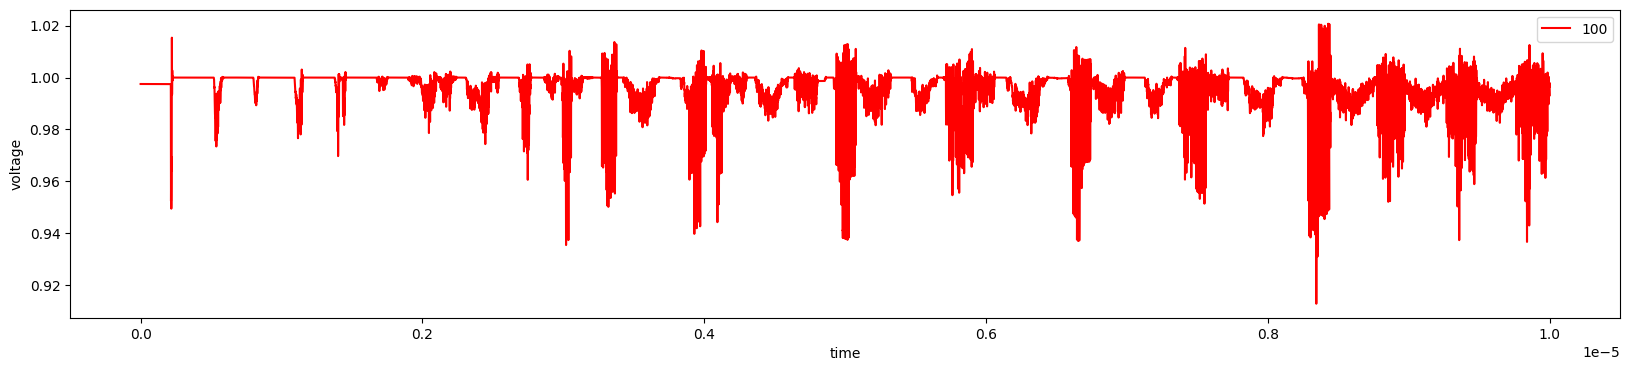

In [15]:
# 参数设置
# 仿真步长
step_time='100p'
# 仿真总时间
end_time='10u'
# 断点次数
stop_number=9750
# 断点时间
stop_time=cores_resistance[0].loc[:stop_number,'Time']
# 根据spice的断点执行规则，
# 1、首先设置好仿真时的断点时间
# 2、开始仿真
# 3、在仿真中途会在设置好的时间中断仿真，此时可以进行一些指令，最后执行resume指令继续仿真，直到下一个断点或终点

#设置断点
for i in range(stop_number):
    ngspice.stop('time = '+str(stop_time[i])+'n')
    
# 禁用错误输出，避免刷屏
sys.stderr = open(os.devnull, 'w')

#开始仿真
#由于pyspice总是在stop时报错command error，但实际没有问题，所以使用try except保证后续代码继续执行
try:
    ngspice.exec_command('tran '+step_time+' '+end_time)
except:
    pass

# 当中断时执行的指令
for i in trange(stop_number):
    #print('%d/%d'%(i,stop_number))
    # 更换负载
    for core in range(4):
        for load in range(6):
            # 当负载为0时计算得到的电阻为无穷大，无法设置，以10000000000作为无穷大
            if cores_resistance[core].loc[i,'Resistance'] == float('inf'):
                ngspice.alter_device(Cores_Load_resistances[core][load],resistance=10000000000)
            else:
                ngspice.alter_device(Cores_Load_resistances[core][load],resistance=cores_resistance[core].loc[i,'Resistance'])
        
    # 由于pyspice总是在stop时报错command error，所以使用try except保证后续代码继续执行
    try:
        ngspice.resume(background=False)
    except: 
        pass

# 恢复错误输出
sys.stderr = sys.__stderr__
# 获取仿真结果
plots = ngspice.plot(simulation=None, plot_name=ngspice.last_plot)
analysis=plots.to_analysis()
# 绘制图像
fig=plt.figure(figsize=(20,4))
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
#fig.savefig("./figure/V100.png",dpi=300)
plt.close()

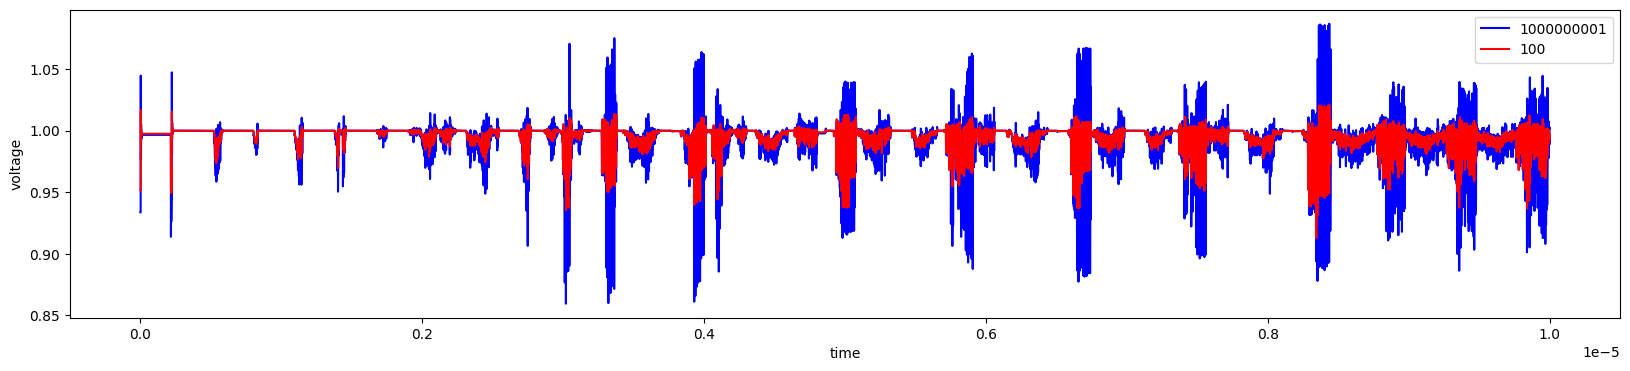

In [8]:
fig=plt.figure(figsize=(20,4))
#plt.plot(np.array(analysis.time),np.array(analysis["1000000002"]), label="1000000002",color='black')
plt.plot(np.array(analysis.time),np.array(analysis["1000000001"]), label="1000000001",color='blue')
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/V100-V1000000001.png",dpi=300)

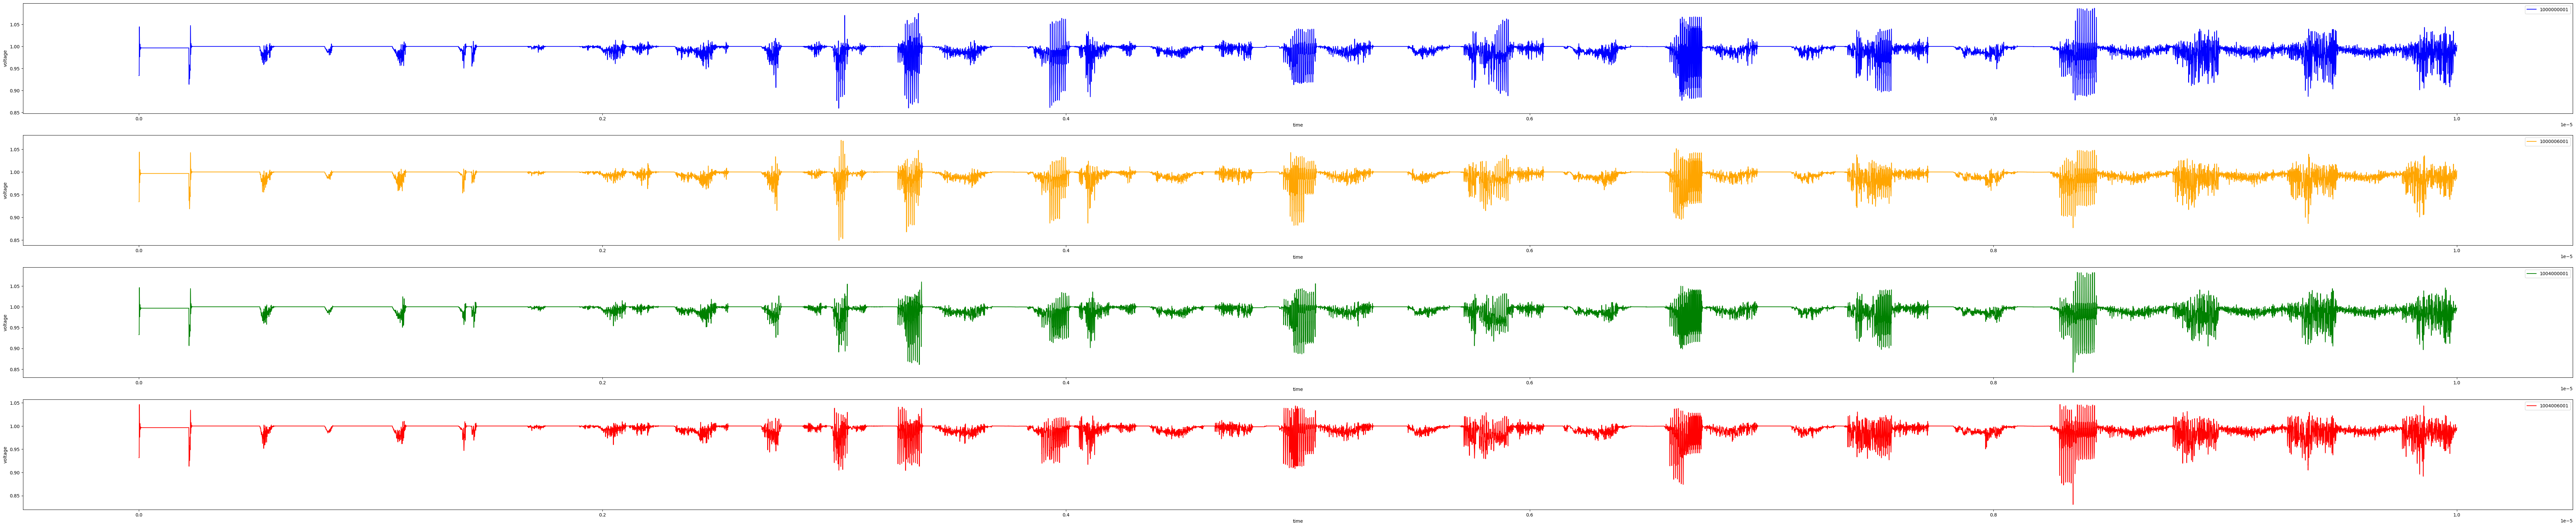

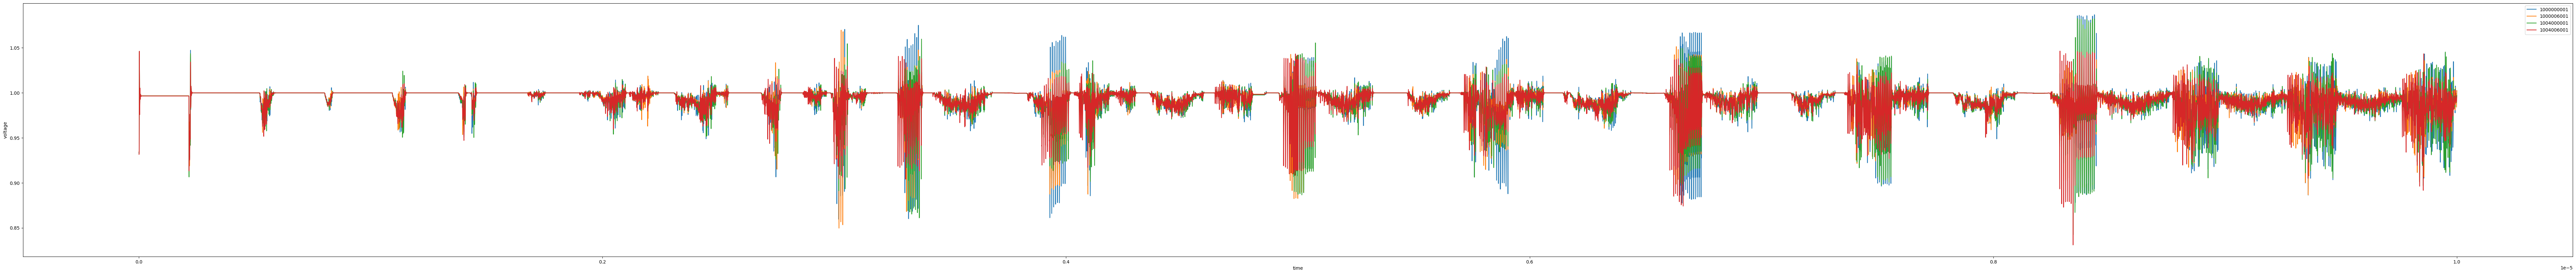

In [15]:
# 每个核心单独画图
pattern3=re.compile('r\d{10}')
fig=plt.figure(figsize=(100,20))
color=['red','green','orange','blue']
i=1
for core in Cores_Load_resistances:
    ax=plt.subplot(len(Cores_Load_resistances),1,i)
    plt_load=pattern3.findall(core[0])[0].replace('r','')
    plt.plot(np.array(analysis.time),np.array(analysis[plt_load]), label=plt_load,color=color.pop())
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("voltage")
    i+=1
plt.show()
fig.savefig("./figure/loads.png",dpi=300)

fig=plt.figure(figsize=(100,10))
for core in Cores_Load_resistances:
    plt_load=pattern3.findall(core[0])[0].replace('r','')
    plt.plot(np.array(analysis.time),np.array(analysis[plt_load]), label=plt_load)
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/load.png",dpi=300)
plt.close()

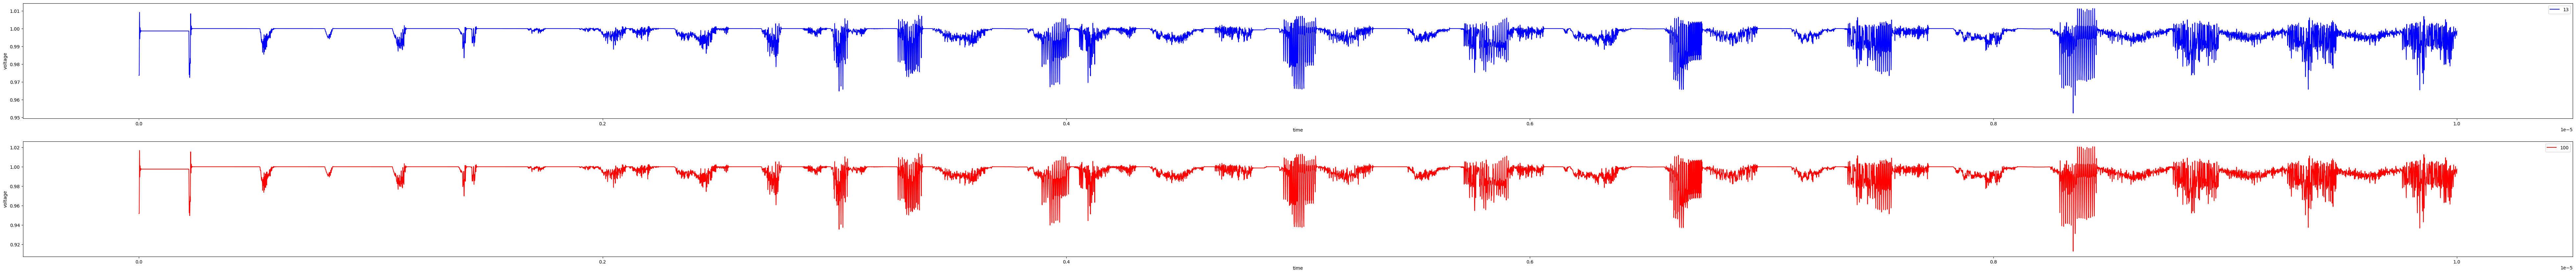

In [12]:
# PDN取点画图
fig=plt.figure(figsize=(100,10))
ax=plt.subplot(2,1,1)
plt.plot(np.array(analysis.time),np.array(analysis["13"]), label="13",color='blue')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
ax=plt.subplot(2,1,2)
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/V100V13.png",dpi=300)